In [42]:
import numpy as np
import pandas as pd

In [43]:
tickers = ["BRK","MMC","PGR","ALL","AJG","MET","PRU","TRV","AIG","FNF","MKL","FAF","HIG","BRO","AIZ","AFL","UNM"]
dataframes = []

for ticker in tickers:
    dataframes.append(pd.read_csv("FinancialNumbers_"+ticker+".csv"))

for i in range(len(tickers)):
    dataframes[i]['Date'] = pd.to_datetime(dataframes[i]['Date'])
    dataframes[i].set_index('Date', inplace=True)

In [44]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2014-12-31 to 2024-03-31
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Total Assets                 38 non-null     int64
 1   Retained Earnings            38 non-null     int64
 2   EBIT                         38 non-null     int64
 3   Shareholders' Equity         38 non-null     int64
 4   Cash & Equivalents           38 non-null     int64
 5   Property, Plant & Equipment  38 non-null     int64
 6   Total Debt                   38 non-null     int64
 7   Working Capital              38 non-null     int64
 8   Total Liabilities            38 non-null     int64
dtypes: int64(9)
memory usage: 3.0 KB


In [45]:
for i in range(len(dataframes)):
    print(list(dataframes[i].columns))

['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equi

In [46]:
def calcRatios(TotalAssets, RetainedEarnings, EBIT, WorkingCapital, Equity, TotalLiabilities):
    WCTA = WorkingCapital/TotalAssets
    RETA = RetainedEarnings/TotalAssets
    EBITTA = EBIT/TotalAssets
    BVETL = Equity/TotalLiabilities
    return [WCTA, RETA, EBITTA, BVETL]

In [47]:
def AltmanZScore(ratios):
    return ratios[0]*6.56 + ratios[1]*3.26 + ratios[2]*6.72 + ratios[3]*1.05

In [48]:
dataframes[0].tail()

,Total Assets,Retained Earnings,EBIT,Shareholders' Equity,Cash & Equivalents,"Property, Plant & Equipment",Total Debt,Working Capital,Total Liabilities
Date,,,,,,,,,
2023-03-31,997072,546631,45282,516260,26747,205855,123624,67410,480812
2023-06-30,1041573,582543,46173,551761,50055,209188,125347,76972,489812
2023-09-30,1019933,569776,-15961,534727,30840,211498,124781,92562,485206
2023-12-31,1069978,607350,47702,570770,38022,221870,133570,173170,499208
2024-03-31,1070035,619925,16529,577785,35549,217500,122754,119906,492250


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
#First forecast - LSTM 1 step forward for BRK
target_columns = ["Total Assets", "Retained Earnings", "EBIT", "Shareholders' Equity", "Working Capital", "Total Liabilities"]
# Initialize scalers for each column
scalers_all = []
scaled_dataframes = []

# Scale each column individually
for i in range(len(dataframes)):
    scaled_data = {}
    scalers = {}
    for col in target_columns:
        scalers[col] = MinMaxScaler()
        scaled_data[col] = scalers[col].fit_transform(dataframes[i][[col]])
    scalers_all.append(scalers)
    scaled_dataframes.append(scaled_data)

In [51]:
scaled_dataframes[0]

{'Total Assets': array([[0.        ],
        [0.00957241],
        [0.02739411],
        [0.03602013],
        [0.04849605],
        [0.11108334],
        [0.12303002],
        [0.14365233],
        [0.17455455],
        [0.23629467],
        [0.25676446],
        [0.28610098],
        [0.32384852],
        [0.32487026],
        [0.34192566],
        [0.38699813],
        [0.33432139],
        [0.39116045],
        [0.43045714],
        [0.48259912],
        [0.53634539],
        [0.43108195],
        [0.48195778],
        [0.55879618],
        [0.63925479],
        [0.65885168],
        [0.71049014],
        [0.72567847],
        [0.79555762],
        [0.8152611 ],
        [0.70565156],
        [0.69175144],
        [0.77659473],
        [0.86591825],
        [0.9476963 ],
        [0.90792917],
        [0.99989525],
        [1.        ]]),
 'Retained Earnings': array([[0.        ],
        [0.01131699],
        [0.02011155],
        [0.04077317],
        [0.0527783 ],
        [0.0650

In [52]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length (how many past steps to use)
seq_length = 3

In [53]:
# Prepare training data
X_trains = []
y_trains = []
for i in range(len(scaled_dataframes)):
    X_train, y_train = {}, {}
    for col in target_columns:
        X_train[col], y_train[col] = create_sequences(scaled_dataframes[i][col], seq_length)
    X_trains.append(X_train)
    y_trains.append(y_train)

In [55]:
predictions = []
models_all = []
for i in range(len(scaled_dataframes)):
    # Initialize models and predictions
    models = {}
    prediction = {}

    # Train an LSTM model for each target column for each company
    for col in target_columns:
        # Build LSTM model
        model = Sequential([
            LSTM(64, activation='relu', input_shape=(seq_length, 1)),
            RepeatVector(1),
            LSTM(64, activation='relu', return_sequences=True),
            TimeDistributed(Dense(1))
        ])

        model.compile(optimizer="adam", loss="mse", metrics = ['mae'])

        #early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
        
        # Train the model
        model.fit(X_train[col], y_train[col], epochs=50, batch_size=8, verbose=1, callbacks = [es])

        # Predict the next step (using the last available sequence)
        last_sequence = X_train[col][-1].reshape(1, seq_length, 1)
        pred = model.predict(last_sequence)

        # Inverse transform to original scale
        pred_original = scalers_all[i][col].inverse_transform(pred.reshape(-1, 1))[0][0]

        # Store model and prediction
        models[col] = model
        prediction[col] = pred_original
    
    predictions.append(prediction)
    models_all.append(models)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2341 - mae: 0.3860
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2855 - mae: 0.4325
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3103 - mae: 0.4646
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2107 - mae: 0.3644
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2196 - mae: 0.3594
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2350 - mae: 0.3905 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1965 - mae: 0.3446
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1690 - mae: 0.3056
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1449 - mae: 0.2890
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1355 - mae: 0.2695  
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0911 - mae: 0.2196
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0554 - mae: 0.1796 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0535 - mae: 0.1924
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0504 - mae: 0.1885
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0607 - mae: 0.205

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.3412 - mae: 0.5333
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3223 - mae: 0.4946
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2631 - mae: 0.4556 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2898 - mae: 0.4833
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2646 - mae: 0.4544 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2020 - mae: 0.3965
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1604 - mae: 0.3272 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1321 - mae: 0.3029 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0708 - mae: 0.2238
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0211 - mae: 0.1143
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0182 - mae: 0.1104
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 - mae: 0.1129
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - mae: 0.0931 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0117 - mae: 0.0935
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - mae: 0.10

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.5063 - mae: 0.6974
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4804 - mae: 0.6806


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4883 - mae: 0.6889
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4433 - mae: 0.6507
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4409 - mae: 0.6543 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3894 - mae: 0.6151
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3686 - mae: 0.5967
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2798 - mae: 0.5209  
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2051 - mae: 0.4442
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1125 - mae: 0.3261 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0468 - mae: 0.1821
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232 - mae: 0.1169 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0462 - mae: 0.1678
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - mae: 0.0799
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.035

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.2221 - mae: 0.3892
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1770 - mae: 0.3380
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1737 - mae: 0.3330
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1663 - mae: 0.3213
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1543 - mae: 0.3152
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1292 - mae: 0.2769
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1205 - mae: 0.2772 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1162 - mae: 0.2685
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0689 - mae: 0.2120 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0509 - mae: 0.1800
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499 - mae: 0.1760
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0422 - mae: 0.1626
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0447 - mae: 0.1569
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411 - mae: 0.1541
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0413 - mae: 0.1602 


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.2916 - mae: 0.4052
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1921 - mae: 0.2976
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2104 - mae: 0.3164
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2369 - mae: 0.3507
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1685 - mae: 0.2685
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1876 - mae: 0.3001  
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1436 - mae: 0.2511
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1428 - mae: 0.2725
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1028 - mae: 0.2433 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0794 - mae: 0.2425
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0549 - mae: 0.2031
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0466 - mae: 0.1794 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0577 - mae: 0.2011 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0507 - mae: 0.1685
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0498 - mae: 0.162

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.2681 - mae: 0.4451
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2995 - mae: 0.4711 
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3407 - mae: 0.4864

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2750 - mae: 0.4450 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2753 - mae: 0.4435
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2256 - mae: 0.4062
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2062 - mae: 0.3814
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1914 - mae: 0.3595
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1392 - mae: 0.2954
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1186 - mae: 0.2711
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0716 - mae: 0.1958 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0488 - mae: 0.17605
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - mae: 0.1569  
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 - mae: 0.1569 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0374 - mae: 0.1545
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383 - mae: 0.156

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.2524 - mae: 0.4000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2694 - mae: 0.4232 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2622 - mae: 0.4283
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2279 - mae: 0.3815 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1969 - mae: 0.3517 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1718 - mae: 0.3191
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1545 - mae: 0.2907 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1417 - mae: 0.2889 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0968 - mae: 0.2344 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0960 - mae: 0.2234 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0599 - mae: 0.1896 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0387 - mae: 0.1625
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0503 - mae: 0.1830
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0520 - mae: 0.1774 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0401 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.3796 - mae: 0.5613
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3602 - mae: 0.5526 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2981 - mae: 0.4962
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2957 - mae: 0.4853 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2668 - mae: 0.4472 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2663 - mae: 0.4531
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2056 - mae: 0.3974
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2240 - mae: 0.4148 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2058 - mae: 0.3853 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1830 - mae: 0.3619 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1421 - mae: 0.3177
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1076 - mae: 0.2616 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0612 - mae: 0.1968
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0564 - mae: 0.1921
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.5127 - mae: 0.7053
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4900 - mae: 0.6887
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4642 - mae: 0.6710 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4070 - mae: 0.6298 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3406 - mae: 0.5663
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3207 - mae: 0.5528 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2587 - mae: 0.5020
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1643 - mae: 0.3960
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0904 - mae: 0.2872 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0331 - mae: 0.1402 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0323 - mae: 0.1360 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0353 - mae: 0.1493
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0226 - mae: 0.1007
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - mae: 0.0973 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0265 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.2884 - mae: 0.4507
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2024 - mae: 0.3661
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2008 - mae: 0.3681 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1815 - mae: 0.3390
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1805 - mae: 0.3282
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1354 - mae: 0.2872 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1615 - mae: 0.3125 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1214 - mae: 0.2707
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0769 - mae: 0.2198 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0702 - mae: 0.2105
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0513 - mae: 0.1802 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0414 - mae: 0.1587
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0500 - mae: 0.1723
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0504 - mae: 0.1666
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0430 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2366 - mae: 0.3502
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2581 - mae: 0.3616 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2360 - mae: 0.3529  
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1970 - mae: 0.2989
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1639 - mae: 0.2695 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1861 - mae: 0.3051
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1534 - mae: 0.2528 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1574 - mae: 0.2757 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0915 - mae: 0.2075 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0775 - mae: 0.2129 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0699 - mae: 0.2089 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0406 - mae: 0.1654 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0440 - mae: 0.1800 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0536 - mae: 0.1983 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0440 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.2302 - mae: 0.4164
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2550 - mae: 0.4307
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2729 - mae: 0.4579
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2410 - mae: 0.4130 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1960 - mae: 0.3669
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1535 - mae: 0.3206 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1235 - mae: 0.2702 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0887 - mae: 0.2260
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0473 - mae: 0.1699 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0380 - mae: 0.1609
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0497 - mae: 0.1763
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0416 - mae: 0.1606
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0389 - mae: 0.1592
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0318 - mae: 0.1414 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0295 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.2495 - mae: 0.4014
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2251 - mae: 0.3703 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1858 - mae: 0.3458
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2435 - mae: 0.3905 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2030 - mae: 0.3433 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1396 - mae: 0.2892
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1310 - mae: 0.2775 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1012 - mae: 0.2287 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0897 - mae: 0.2201
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0590 - mae: 0.1957 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0492 - mae: 0.1847 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0586 - mae: 0.2000
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0437 - mae: 0.1738 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0493 - mae: 0.1847 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0484 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.3426 - mae: 0.5276
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2917 - mae: 0.4881
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3028 - mae: 0.5014

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2907 - mae: 0.4809 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2885 - mae: 0.4819 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2415 - mae: 0.4411
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2011 - mae: 0.3894 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1763 - mae: 0.3627 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1221 - mae: 0.2890 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0708 - mae: 0.2155 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0323 - mae: 0.1412
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150 - mae: 0.1038 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233 - mae: 0.1165 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - mae: 0.0893
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - mae: 0.0883
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.5328 - mae: 0.7205
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4746 - mae: 0.6693
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4943 - mae: 0.6903
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4294 - mae: 0.6337 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4153 - mae: 0.6360 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3684 - mae: 0.5856 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3453 - mae: 0.5783
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2737 - mae: 0.5152
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2104 - mae: 0.4449
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1135 - mae: 0.3279 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0469 - mae: 0.1880
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - mae: 0.0944 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0352 - mae: 0.1555 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188 - mae: 0.1099 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2138 - mae: 0.3663
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1849 - mae: 0.3460 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2182 - mae: 0.3823  
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1721 - mae: 0.3357
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1441 - mae: 0.2887 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1337 - mae: 0.2824 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1222 - mae: 0.2789
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0759 - mae: 0.2117 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0796 - mae: 0.2127 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0433 - mae: 0.1597 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - mae: 0.1577 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0511 - mae: 0.1745 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0495 - mae: 0.1732
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0621 - mae: 0.1902
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0473 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2332 - mae: 0.3513
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1697 - mae: 0.2775 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2325 - mae: 0.3553
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2282 - mae: 0.3453
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2157 - mae: 0.3234 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1947 - mae: 0.3158
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1875 - mae: 0.3046 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1314 - mae: 0.2357 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1033 - mae: 0.2120 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0904 - mae: 0.2282
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0586 - mae: 0.2007 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0333 - mae: 0.1588
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0548 - mae: 0.1945
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398 - mae: 0.1737 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0429 - mae: 0.15

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.2833 - mae: 0.4696
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3127 - mae: 0.4949 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2292 - mae: 0.4099 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2193 - mae: 0.4051 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2305 - mae: 0.4108 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2448 - mae: 0.4256 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2427 - mae: 0.4130 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2079 - mae: 0.3844
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1195 - mae: 0.2678
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1159 - mae: 0.2654
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0658 - mae: 0.1899 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0425 - mae: 0.1669
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0420 - mae: 0.1700 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0428 - mae: 0.1668
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0368 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.3045 - mae: 0.4539 
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2504 - mae: 0.4022
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2673 - mae: 0.41497
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2053 - mae: 0.3644 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2632 - mae: 0.4085 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1974 - mae: 0.3490 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1712 - mae: 0.3160 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1566 - mae: 0.2972 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1112 - mae: 0.2418 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0868 - mae: 0.2158
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0599 - mae: 0.1854 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0425 - mae: 0.1684 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0400 - mae: 0.1645
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0472 - mae: 0.1810 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0530 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.2978 - mae: 0.4951
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3116 - mae: 0.4959 
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3126 - mae: 0.4856

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3026 - mae: 0.4900 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2999 - mae: 0.4967
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2592 - mae: 0.4443
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2529 - mae: 0.4447 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2042 - mae: 0.3975 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1863 - mae: 0.3625
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1324 - mae: 0.3083
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0989 - mae: 0.2535 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0432 - mae: 0.1647 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - mae: 0.1085 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0178 - mae: 0.1029
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - mae: 0.1041  
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.5458 - mae: 0.7277
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4744 - mae: 0.6677
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4705 - mae: 0.6773 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4311 - mae: 0.6352 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4194 - mae: 0.6387 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3841 - mae: 0.6047 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3289 - mae: 0.5654 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2750 - mae: 0.5168
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2177 - mae: 0.4571 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1370 - mae: 0.3600 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0502 - mae: 0.2009 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0235 - mae: 0.0894 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0389 - mae: 0.1667 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0432 - mae: 0.1352
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0252 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2143 - mae: 0.3789
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1956 - mae: 0.3570 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2253 - mae: 0.3945
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1555 - mae: 0.3069
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1732 - mae: 0.3254
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1499 - mae: 0.3123 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1192 - mae: 0.2693
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1132 - mae: 0.2688 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0831 - mae: 0.2214  
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0550 - mae: 0.1865 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0454 - mae: 0.1677 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0481 - mae: 0.1696 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0392 - mae: 0.1511
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0490 - mae: 0.1723 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0444 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2764 - mae: 0.3932
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2292 - mae: 0.3416 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2303 - mae: 0.3418
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2394 - mae: 0.3521  
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2383 - mae: 0.3652
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2258 - mae: 0.3402 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1590 - mae: 0.2754 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1199 - mae: 0.2210 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1374 - mae: 0.2820
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0977 - mae: 0.2430 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0570 - mae: 0.2083 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0437 - mae: 0.1726 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0581 - mae: 0.2054
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0516 - mae: 0.1716
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0453 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2805 - mae: 0.4572
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2706 - mae: 0.4574 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2238 - mae: 0.4073 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2672 - mae: 0.4451 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1790 - mae: 0.3573 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2143 - mae: 0.3824
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1463 - mae: 0.3010 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1255 - mae: 0.2785  
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0645 - mae: 0.1868 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0553 - mae: 0.1884 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0361 - mae: 0.1546 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0429 - mae: 0.1688 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0378 - mae: 0.1573
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0392 - mae: 0.1674
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0411 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.2778 - mae: 0.4412
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2956 - mae: 0.4458


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2584 - mae: 0.4073
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1990 - mae: 0.3533 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1749 - mae: 0.3255 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1533 - mae: 0.2908 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1370 - mae: 0.2780
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1344 - mae: 0.2747 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0658 - mae: 0.1953 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0541 - mae: 0.1910
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0343 - mae: 0.1461
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0391 - mae: 0.1583 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - mae: 0.1942 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0486 - mae: 0.1800 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.3050 - mae: 0.4927
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2979 - mae: 0.4759
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2958 - mae: 0.4849
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2563 - mae: 0.4462
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1983 - mae: 0.3834 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1828 - mae: 0.3696 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1591 - mae: 0.3391 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1695 - mae: 0.3571 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1037 - mae: 0.2719
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0648 - mae: 0.2027 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0339 - mae: 0.1436 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0163 - mae: 0.1029 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0189 - mae: 0.1038 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147 - mae: 0.0988
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.4859 - mae: 0.6776
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4902 - mae: 0.6847 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4582 - mae: 0.66247
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4662 - mae: 0.6744 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4220 - mae: 0.6256
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3884 - mae: 0.6017
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3590 - mae: 0.5785
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2903 - mae: 0.5275 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2351 - mae: 0.4761 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1531 - mae: 0.3800 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0645 - mae: 0.2367 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198 - mae: 0.0926
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0627 - mae: 0.1921 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0442 - mae: 0.1342
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - mae: 0.0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.2329 - mae: 0.4078
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1874 - mae: 0.3541 
Epoch 3/50
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2612 - mae: 0.4157

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2245 - mae: 0.3869
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1726 - mae: 0.3277
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1452 - mae: 0.2989 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1488 - mae: 0.2938
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1588 - mae: 0.3253
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1498 - mae: 0.3031 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1302 - mae: 0.2869 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0796 - mae: 0.2143 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0617 - mae: 0.1954
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0427 - mae: 0.1642 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0586 - mae: 0.1874
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0533 - mae: 0.1721
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0374 - mae: 0.15

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.2545 - mae: 0.3684
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2394 - mae: 0.3525 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2476 - mae: 0.3671 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2012 - mae: 0.3076 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1810 - mae: 0.2866
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1694 - mae: 0.2702 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1731 - mae: 0.2786
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1522 - mae: 0.2518 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1042 - mae: 0.2126
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0806 - mae: 0.2156 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0595 - mae: 0.2136
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0523 - mae: 0.1798 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0422 - mae: 0.1769
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0394 - mae: 0.1596
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0465 - mae: 0.1

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.3004 - mae: 0.4770
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2899 - mae: 0.4601 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2746 - mae: 0.4431
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2493 - mae: 0.4183
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2012 - mae: 0.3856 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2021 - mae: 0.3718
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1861 - mae: 0.3524
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1393 - mae: 0.2903
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0660 - mae: 0.1860 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0374 - mae: 0.1567
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0485 - mae: 0.1801  
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0457 - mae: 0.1732 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0397 - mae: 0.1686 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0352 - mae: 0.1520
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412 - mae: 0.16

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2236 - mae: 0.3896
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2254 - mae: 0.3721
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2437 - mae: 0.3996
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2448 - mae: 0.3925 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2354 - mae: 0.3928
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1948 - mae: 0.3411 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1657 - mae: 0.3110 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1692 - mae: 0.3105 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1145 - mae: 0.2497 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0920 - mae: 0.2234 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0742 - mae: 0.2054
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0520 - mae: 0.1860
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0490 - mae: 0.1778 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0542 - mae: 0.1876
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0407 - mae: 0.1

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - loss: 0.3312 - mae: 0.5152
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2800 - mae: 0.4793
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2896 - mae: 0.4767
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2702 - mae: 0.4564 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2954 - mae: 0.4749
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2114 - mae: 0.4016
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2243 - mae: 0.4204 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1822 - mae: 0.3713 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1330 - mae: 0.2995 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0717 - mae: 0.2281 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0309 - mae: 0.1357
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - mae: 0.0986
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - mae: 0.1014 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - mae: 0.0857 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.09

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.5052 - mae: 0.6968
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5054 - mae: 0.7007
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4745 - mae: 0.6807 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4466 - mae: 0.6572 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4257 - mae: 0.6408 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3563 - mae: 0.5844 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3120 - mae: 0.5465
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2397 - mae: 0.4837 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1707 - mae: 0.4026 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0834 - mae: 0.2683
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0268 - mae: 0.1067
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0387 - mae: 0.1661
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0516 - mae: 0.1557
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0179 - mae: 0.0855
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.2164 - mae: 0.3853
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1870 - mae: 0.3516
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1847 - mae: 0.3522
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1710 - mae: 0.3248
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1966 - mae: 0.3544
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1231 - mae: 0.2768
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1219 - mae: 0.2751 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0785 - mae: 0.2187
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0613 - mae: 0.1932 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0551 - mae: 0.1892 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0381 - mae: 0.1497 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499 - mae: 0.1712
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349 - mae: 0.1379
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0473 - mae: 0.1677
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0446 - mae: 0.1669


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.2761 - mae: 0.3860
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2679 - mae: 0.3890 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2186 - mae: 0.3297
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1659 - mae: 0.2745 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1727 - mae: 0.2811 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1438 - mae: 0.2473
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1266 - mae: 0.2298
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1030 - mae: 0.2213 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0709 - mae: 0.2066
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0595 - mae: 0.1943 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0433 - mae: 0.1773
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0639 - mae: 0.2156
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0555 - mae: 0.1735 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0348 - mae: 0.1438 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0372 - mae: 0.14

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.3061 - mae: 0.4780
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3268 - mae: 0.4989
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2286 - mae: 0.4025
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2386 - mae: 0.4150 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2573 - mae: 0.4343
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2093 - mae: 0.3869
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1458 - mae: 0.3198 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1648 - mae: 0.3286  
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1095 - mae: 0.2616 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0506 - mae: 0.1729
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0461 - mae: 0.1728 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0352 - mae: 0.1560 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0430 - mae: 0.1706  
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0478 - mae: 0.1790 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0423 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2681 - mae: 0.4253
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2454 - mae: 0.3930
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2507 - mae: 0.3980 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2317 - mae: 0.3904 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1988 - mae: 0.3357
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2055 - mae: 0.3582 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1621 - mae: 0.3094 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1522 - mae: 0.2978
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0778 - mae: 0.2012
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0660 - mae: 0.1860 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0579 - mae: 0.2003 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0474 - mae: 0.1822 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0517 - mae: 0.1731 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0453 - mae: 0.1698 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0484 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.3008 - mae: 0.4846
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2819 - mae: 0.4560
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2889 - mae: 0.4766
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2447 - mae: 0.4336 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2485 - mae: 0.4400 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2253 - mae: 0.4209  
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2049 - mae: 0.3960 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2118 - mae: 0.3953
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1496 - mae: 0.3314 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0984 - mae: 0.2585
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0369 - mae: 0.1545
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - mae: 0.0917 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0277 - mae: 0.1253 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - mae: 0.0911  
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.5167 - mae: 0.7070
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4834 - mae: 0.6809 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4375 - mae: 0.6404
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4093 - mae: 0.6173
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3848 - mae: 0.6003
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3395 - mae: 0.5747 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2665 - mae: 0.5043
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1902 - mae: 0.4266 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1142 - mae: 0.3274 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0411 - mae: 0.1828
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218 - mae: 0.0999 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0356 - mae: 0.1599
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0292 - mae: 0.1140 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0346 - mae: 0.1106 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0310 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1932 - mae: 0.3569
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2226 - mae: 0.3917
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1985 - mae: 0.3650 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1601 - mae: 0.3080
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1691 - mae: 0.3280 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1265 - mae: 0.2739 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1339 - mae: 0.2938
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1159 - mae: 0.2631 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0753 - mae: 0.2130
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0659 - mae: 0.1938
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0555 - mae: 0.1822
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0401 - mae: 0.1500
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0500 - mae: 0.1665 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0450 - mae: 0.1680
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0407 - mae: 0.15

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.2150 - mae: 0.3248
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2440 - mae: 0.3570
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2435 - mae: 0.3566 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1763 - mae: 0.2776 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2375 - mae: 0.3461
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1664 - mae: 0.2661
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1975 - mae: 0.2933 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1241 - mae: 0.2169 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1382 - mae: 0.2559
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0877 - mae: 0.2256
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0820 - mae: 0.2376 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0492 - mae: 0.1983
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0500 - mae: 0.1796
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0557 - mae: 0.1957
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0548 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.3395 - mae: 0.5035
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2977 - mae: 0.4742 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2445 - mae: 0.4239 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2418 - mae: 0.4229 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2224 - mae: 0.3941 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1778 - mae: 0.3566
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2286 - mae: 0.3955 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1467 - mae: 0.3006
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1054 - mae: 0.2413
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0828 - mae: 0.2092 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0409 - mae: 0.1639 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0472 - mae: 0.1712
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0469 - mae: 0.1663
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0329 - mae: 0.1521
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2746 - mae: 0.4294
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2296 - mae: 0.3975
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3662 - mae: 0.5162

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2779 - mae: 0.4325 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2009 - mae: 0.3593 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1930 - mae: 0.3394 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1788 - mae: 0.3316
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1841 - mae: 0.3261 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1874 - mae: 0.3345
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1411 - mae: 0.2885
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1386 - mae: 0.2744 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0855 - mae: 0.2075
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0572 - mae: 0.1888 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511 - mae: 0.1916 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0510 - mae: 0.1903
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0560 - mae: 0.18

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.3077 - mae: 0.4887
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3386 - mae: 0.5283
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3179 - mae: 0.4993
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2922 - mae: 0.4781
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2782 - mae: 0.4709
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2307 - mae: 0.4207
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2213 - mae: 0.4116 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1992 - mae: 0.3752
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1975 - mae: 0.3722  
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1328 - mae: 0.3047
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0986 - mae: 0.2634
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0812 - mae: 0.2405 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 - mae: 0.1476
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - mae: 0.1128 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - mae: 0.106

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.4921 - mae: 0.6824
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4705 - mae: 0.6725 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4596 - mae: 0.6554
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4641 - mae: 0.6713
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4118 - mae: 0.6302
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3697 - mae: 0.5864
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3390 - mae: 0.5742  
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2695 - mae: 0.5055
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2127 - mae: 0.4523 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1165 - mae: 0.3288 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0478 - mae: 0.1815 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0336 - mae: 0.1345
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0594 - mae: 0.1814
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0251 - mae: 0.0938
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - mae: 0.09

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1937 - mae: 0.3588
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1611 - mae: 0.3202
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1786 - mae: 0.3448 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2333 - mae: 0.4021
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1971 - mae: 0.3564
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1699 - mae: 0.3283
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1244 - mae: 0.2752
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1359 - mae: 0.2969
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1085 - mae: 0.2630
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0570 - mae: 0.1883
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0404 - mae: 0.1472
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0536 - mae: 0.1672
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0540 - mae: 0.1640 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0466 - mae: 0.1690
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0551 - mae: 0.1842
Ep

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2430 - mae: 0.3581
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2123 - mae: 0.3185
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2987 - mae: 0.4068

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2399 - mae: 0.3545 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2047 - mae: 0.3104 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1736 - mae: 0.2821
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2113 - mae: 0.3258
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2007 - mae: 0.3109 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1664 - mae: 0.2695 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1527 - mae: 0.2897
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1072 - mae: 0.2278 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0719 - mae: 0.2085 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0588 - mae: 0.1984
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0494 - mae: 0.1928 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0433 - mae: 0.1858
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0357 - mae: 0.14

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2914 - mae: 0.4723
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3182 - mae: 0.4889 
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2849 - mae: 0.4609

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2771 - mae: 0.4539
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2835 - mae: 0.4692
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2699 - mae: 0.4478 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2220 - mae: 0.3980 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1728 - mae: 0.3404
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1569 - mae: 0.3218 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1645 - mae: 0.3277 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0782 - mae: 0.2069 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0523 - mae: 0.1775 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396 - mae: 0.1654  
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0442 - mae: 0.1760 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0379 - mae: 0.1628 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0364 - mae

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.2967 - mae: 0.4419
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2489 - mae: 0.3914 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2430 - mae: 0.3913 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2246 - mae: 0.3756
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2398 - mae: 0.3822 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1995 - mae: 0.3409 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1491 - mae: 0.3025  
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1356 - mae: 0.2799
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0866 - mae: 0.2010
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0557 - mae: 0.1784
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0510 - mae: 0.1823
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0538 - mae: 0.1879 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0454 - mae: 0.1611
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0488 - mae: 0.1793 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0542 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.3468 - mae: 0.5354
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3008 - mae: 0.4887
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2555 - mae: 0.4391 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2628 - mae: 0.4519  
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2218 - mae: 0.4152 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2523 - mae: 0.4445 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2045 - mae: 0.3831 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1538 - mae: 0.3253
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1234 - mae: 0.2931 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0789 - mae: 0.2261 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0290 - mae: 0.1394
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141 - mae: 0.0859 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0178 - mae: 0.1102  
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0220 - mae: 0.1011 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - m

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.5215 - mae: 0.7128
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5057 - mae: 0.7016 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4794 - mae: 0.6832 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4377 - mae: 0.6463 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3957 - mae: 0.6075
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3675 - mae: 0.5953 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3256 - mae: 0.5604
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2537 - mae: 0.4906
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1831 - mae: 0.4165 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0898 - mae: 0.2892
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0268 - mae: 0.1232
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0467 - mae: 0.1538
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0410 - mae: 0.1667 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - mae: 0.0856 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0161 - mae

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.2194 - mae: 0.3783
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1638 - mae: 0.3150 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1876 - mae: 0.3395
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1688 - mae: 0.3276
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1740 - mae: 0.3202
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1524 - mae: 0.2992  
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1497 - mae: 0.3037
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1462 - mae: 0.3109 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1174 - mae: 0.2712 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0974 - mae: 0.2437 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0653 - mae: 0.1988 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0476 - mae: 0.1736 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - mae: 0.1505 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0472 - mae: 0.1663
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0619 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2500 - mae: 0.3681
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2313 - mae: 0.3384
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2502 - mae: 0.3692 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2081 - mae: 0.3279
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1794 - mae: 0.2805
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1688 - mae: 0.2741 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1479 - mae: 0.2537
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1220 - mae: 0.2311
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1004 - mae: 0.2261 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0968 - mae: 0.2543 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0673 - mae: 0.2170
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0464 - mae: 0.1770
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0569 - mae: 0.1925 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0426 - mae: 0.1723 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0499 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.3209 - mae: 0.4904
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2784 - mae: 0.4465 
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0860 - mae: 0.2789

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2135 - mae: 0.3969 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2434 - mae: 0.4202 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1829 - mae: 0.3642 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2209 - mae: 0.3896 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1840 - mae: 0.3469 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1142 - mae: 0.2687 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0716 - mae: 0.2090 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0425 - mae: 0.1555
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0351 - mae: 0.1575
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0453 - mae: 0.1636 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0469 - mae: 0.1730
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0310 - mae: 0.1426 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0408 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.2057 - mae: 0.3583
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2527 - mae: 0.4064
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1972 - mae: 0.3567
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1980 - mae: 0.3550  
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1974 - mae: 0.3463
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1497 - mae: 0.2983 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1936 - mae: 0.3345
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1386 - mae: 0.2772
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1058 - mae: 0.2368
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0576 - mae: 0.1841 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0607 - mae: 0.2121 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0582 - mae: 0.2073 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0550 - mae: 0.2001
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0532 - mae: 0.1996
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0441 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2749 - mae: 0.4665
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3224 - mae: 0.5122 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2940 - mae: 0.4792
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3312 - mae: 0.5180 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2842 - mae: 0.4775 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2492 - mae: 0.4396
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2226 - mae: 0.4127
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1859 - mae: 0.3780 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1384 - mae: 0.3181 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0739 - mae: 0.2256
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0359 - mae: 0.1570 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - mae: 0.0977 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0284 - mae: 0.1295 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0243 - mae: 0.1041 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.4840 - mae: 0.6771
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4839 - mae: 0.6740 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4727 - mae: 0.6763 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4374 - mae: 0.6520 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4026 - mae: 0.6183
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3327 - mae: 0.5653
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2978 - mae: 0.5383
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2057 - mae: 0.4445 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1278 - mae: 0.3459
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0505 - mae: 0.1957
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 - mae: 0.1113 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0367 - mae: 0.1510 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0209 - mae: 0.1008
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0181 - mae: 0.0882
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0313 - mae

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.2027 - mae: 0.3799
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1856 - mae: 0.3419 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2066 - mae: 0.3611
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1817 - mae: 0.3408 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1671 - mae: 0.3339 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1571 - mae: 0.3173  
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1252 - mae: 0.2761 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0802 - mae: 0.2280 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0686 - mae: 0.2111 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0434 - mae: 0.1582 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0349 - mae: 0.1342 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0417 - mae: 0.1487  
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0490 - mae: 0.1653  
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0460 - mae: 0.1575 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0429 - m

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.3461 - mae: 0.4559
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2592 - mae: 0.3746 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2038 - mae: 0.3096
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2283 - mae: 0.3377


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2038 - mae: 0.3113 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1762 - mae: 0.2893 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1567 - mae: 0.2627 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1540 - mae: 0.2798
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0991 - mae: 0.2273  
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0727 - mae: 0.2136 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0450 - mae: 0.1848 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0484 - mae: 0.1771 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0409 - mae: 0.1786
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0474 - mae: 0.1615  
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0356 - mae: 0.1492
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0349 - mae: 0.1445
Epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.3427 - mae: 0.5180
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2377 - mae: 0.4236 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2664 - mae: 0.4398  
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2459 - mae: 0.4248
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2128 - mae: 0.3962
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2101 - mae: 0.3822
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1474 - mae: 0.3114 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1139 - mae: 0.2717 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0871 - mae: 0.2307 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0452 - mae: 0.1543  
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0341 - mae: 0.1479
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0377 - mae: 0.1547 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0407 - mae: 0.1548
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0339 - mae: 0.1528  
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0385 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2274 - mae: 0.3818
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2582 - mae: 0.4007
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2322 - mae: 0.3895
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1952 - mae: 0.3514 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2253 - mae: 0.3653  
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2027 - mae: 0.3478 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1779 - mae: 0.3198
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1676 - mae: 0.3169
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1656 - mae: 0.3058  
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1291 - mae: 0.2616 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1075 - mae: 0.2480
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0554 - mae: 0.1803  
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0482 - mae: 0.1813
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0514 - mae: 0.1930 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0476 - m

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.3342 - mae: 0.5185
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2875 - mae: 0.4784
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2913 - mae: 0.4723 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2973 - mae: 0.4944
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2431 - mae: 0.4435 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1964 - mae: 0.3837 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1526 - mae: 0.3241
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1169 - mae: 0.2946
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0737 - mae: 0.2175
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0206 - mae: 0.1084 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - mae: 0.0890 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0198 - mae: 0.1126 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mae: 0.0719
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - mae: 0.0796 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.5144 - mae: 0.7035
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4746 - mae: 0.6755
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4739 - mae: 0.6772
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4289 - mae: 0.6425 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3928 - mae: 0.6179 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3516 - mae: 0.5739 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3252 - mae: 0.5613 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2402 - mae: 0.4814 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1778 - mae: 0.4099 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0859 - mae: 0.2814
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0282 - mae: 0.1321
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0309 - mae: 0.1299 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0569 - mae: 0.1742 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - mae: 0.0861
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0313 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.2214 - mae: 0.3858
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2124 - mae: 0.3708 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1863 - mae: 0.3460 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2251 - mae: 0.3693 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1857 - mae: 0.3422
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1542 - mae: 0.3092
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1762 - mae: 0.3375 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1287 - mae: 0.2815 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1145 - mae: 0.2630
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0731 - mae: 0.2023
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0674 - mae: 0.2056 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0406 - mae: 0.1538 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0438 - mae: 0.1606 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0640 - mae: 0.1978 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0369 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.2647 - mae: 0.3772
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2500 - mae: 0.3620 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2064 - mae: 0.3183 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2197 - mae: 0.3280
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1852 - mae: 0.2943
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2055 - mae: 0.3199 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1659 - mae: 0.2662
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1893 - mae: 0.3152
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1362 - mae: 0.2603
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0828 - mae: 0.2329  
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0698 - mae: 0.2193
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0546 - mae: 0.1900 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0517 - mae: 0.1971 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0459 - mae: 0.1716 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0390 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.3147 - mae: 0.4810
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3033 - mae: 0.4685
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2024 - mae: 0.3797 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2628 - mae: 0.4422
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1925 - mae: 0.3758 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2136 - mae: 0.3779
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1655 - mae: 0.3352 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1215 - mae: 0.2808 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1162 - mae: 0.2602 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0586 - mae: 0.1866
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0289 - mae: 0.1352 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0349 - mae: 0.1514
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0500 - mae: 0.1689 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0380 - mae: 0.1625 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0324 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2620 - mae: 0.4253
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2753 - mae: 0.4283 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2285 - mae: 0.3958
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2456 - mae: 0.3893
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2640 - mae: 0.4155 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2073 - mae: 0.3495
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1474 - mae: 0.2971
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1957 - mae: 0.3414
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1191 - mae: 0.2549 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1057 - mae: 0.2301 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0804 - mae: 0.2043
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0443 - mae: 0.1651
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0489 - mae: 0.1850
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0470 - mae: 0.1782 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0518 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.3057 - mae: 0.4899
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3090 - mae: 0.4900 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2960 - mae: 0.4882 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2977 - mae: 0.4807 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2079 - mae: 0.3908
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2840 - mae: 0.4701
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1842 - mae: 0.3679 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1401 - mae: 0.3110
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1315 - mae: 0.3056
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1203 - mae: 0.2842
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0559 - mae: 0.1872 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 - mae: 0.1306 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - mae: 0.1004 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - mae: 0.1125
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.5129 - mae: 0.7019
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4698 - mae: 0.6751 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4311 - mae: 0.6362
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4438 - mae: 0.6570 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3987 - mae: 0.6173 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3828 - mae: 0.6102 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2997 - mae: 0.5368 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2448 - mae: 0.4861 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1512 - mae: 0.3790
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0554 - mae: 0.2180
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260 - mae: 0.1073 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0432 - mae: 0.1746
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297 - mae: 0.1193 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0213 - mae: 0.0948
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0219 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.2115 - mae: 0.3704
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1874 - mae: 0.3451 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2025 - mae: 0.3569 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1948 - mae: 0.3551
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1690 - mae: 0.3262 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1959 - mae: 0.3506
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1478 - mae: 0.3036
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1286 - mae: 0.2824
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1220 - mae: 0.2716
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1190 - mae: 0.2857 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0603 - mae: 0.1815 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0543 - mae: 0.1867
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0457 - mae: 0.1669 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0546 - mae: 0.1777
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0370 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.2369 - mae: 0.3569
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2226 - mae: 0.3314
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2320 - mae: 0.3453
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1581 - mae: 0.2535
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1932 - mae: 0.3121 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2222 - mae: 0.3343 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1162 - mae: 0.2174
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0987 - mae: 0.2052 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0817 - mae: 0.2171 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0796 - mae: 0.2239 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0561 - mae: 0.1948
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0493 - mae: 0.1769
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0435 - mae: 0.1799
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0441 - mae: 0.1597 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0501 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.2960 - mae: 0.4785
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2813 - mae: 0.4637
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2822 - mae: 0.4610
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2586 - mae: 0.4320
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2190 - mae: 0.3924
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2140 - mae: 0.3828 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1399 - mae: 0.2993 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1193 - mae: 0.2618
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0817 - mae: 0.2119 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0539 - mae: 0.1809 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0371 - mae: 0.1585 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0466 - mae: 0.1741 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0352 - mae: 0.1527
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0343 - mae: 0.1524
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0390 - mae: 0.

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.2228 - mae: 0.3825
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2376 - mae: 0.3920 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2516 - mae: 0.4094 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2823 - mae: 0.4281
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2316 - mae: 0.3911 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2463 - mae: 0.3890 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1852 - mae: 0.3421 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2109 - mae: 0.3574 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1606 - mae: 0.3043
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1120 - mae: 0.2305
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1020 - mae: 0.2413 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0579 - mae: 0.1896 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0404 - mae: 0.1632
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0509 - mae: 0.1899
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0475 - mae: 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.2947 - mae: 0.4934
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2776 - mae: 0.4678
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2316 - mae: 0.4160 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2866 - mae: 0.4785
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2380 - mae: 0.4285
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2299 - mae: 0.4123
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2037 - mae: 0.3912 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2083 - mae: 0.3973 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1377 - mae: 0.3174
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1053 - mae: 0.2721
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0476 - mae: 0.1763
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - mae: 0.1001 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0197 - mae: 0.1105
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0190 - mae: 0.1007
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - mae: 0.0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.5344 - mae: 0.7218
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4878 - mae: 0.6846 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4786 - mae: 0.6808 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4250 - mae: 0.6315 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4130 - mae: 0.6356 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3736 - mae: 0.6007 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3105 - mae: 0.5410 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2844 - mae: 0.5214 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1892 - mae: 0.4280 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1411 - mae: 0.3603 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0528 - mae: 0.2054 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 - mae: 0.0931
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0288 - mae: 0.1442
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0264 - mae: 0.1195 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257 - mae

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.1943 - mae: 0.3541
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1874 - mae: 0.3526
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2198 - mae: 0.3733
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1789 - mae: 0.3230 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1443 - mae: 0.3071 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1813 - mae: 0.3447
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1566 - mae: 0.3086
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1199 - mae: 0.2745
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0907 - mae: 0.2360
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0945 - mae: 0.2440 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0446 - mae: 0.1614  
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0468 - mae: 0.1680 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0455 - mae: 0.1672 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0538 - mae: 0.1809
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0572 - mae: 0

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9289s 4ms/step - loss: 0.2178 - mae: 0.3319     
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2801 - mae: 0.3947  
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2543 - mae: 0.3726  
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2086 - mae: 0.3166  
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1731 - mae: 0.2803 


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1826 - mae: 0.2872 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1696 - mae: 0.2819 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1904 - mae: 0.3210 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0902 - mae: 0.2036 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0766 - mae: 0.2192  
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0609 - mae: 0.1999 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0512 - mae: 0.1839 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0484 - mae: 0.1906 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0478 - mae: 0.1760 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0342 - mae: 0.1504 
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0483 - mae: 0.1698 
Epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0369 - mae: 0.1470 
Epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 156462s 27ms/step - loss: 0.2946 - mae: 0.4798 
Epoch 2/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2661 - mae: 0.4471
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2714 - mae: 0.4503
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2186 - mae: 0.4012
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2318 - mae: 0.4173
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2259 - mae: 0.4043
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2275 - mae: 0.3987
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1350 - mae: 0.2976 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1311 - mae: 0.2896
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1209 - mae: 0.2657
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0593 - mae: 0.1805
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0365 - mae: 0.1557
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0413 - mae: 0.1655 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0333 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2593 - mae: 0.4067
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2444 - mae: 0.3904 
Epoch 3/50
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1938 - mae: 0.3435

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2232 - mae: 0.3763 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2206 - mae: 0.3749 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2426 - mae: 0.3973 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1878 - mae: 0.3421 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1992 - mae: 0.3442
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1369 - mae: 0.2691
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1054 - mae: 0.2290 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1056 - mae: 0.2320  
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0734 - mae: 0.1975 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0727 - mae: 0.2036 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0443 - mae: 0.1768 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0484 - mae: 0.1823
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0510 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.3197 - mae: 0.5063
Epoch 2/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2798 - mae: 0.4638
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3320 - mae: 0.5212
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2976 - mae: 0.4875
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2629 - mae: 0.4450
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2519 - mae: 0.4384
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2412 - mae: 0.4370
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2271 - mae: 0.4144
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1947 - mae: 0.3676
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1758 - mae: 0.3557
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1583 - mae: 0.3302
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0895 - mae: 0.2467
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0394 - mae: 0.1534
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0132 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - loss: 0.5272 - mae: 0.7131
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4934 - mae: 0.6815
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4609 - mae: 0.6575
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4691 - mae: 0.6622 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4643 - mae: 0.6721
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4307 - mae: 0.6480
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4110 - mae: 0.6193
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3760 - mae: 0.6025
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3549 - mae: 0.5869
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2991 - mae: 0.5356 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2302 - mae: 0.4720
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1452 - mae: 0.3668 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0544 - mae: 0.2062
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0406 - mae: 0.1394
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0440 - 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2379 - mae: 0.3961
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1889 - mae: 0.3520 


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2197 - mae: 0.3706
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2115 - mae: 0.3692 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1825 - mae: 0.3445
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1626 - mae: 0.3333
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0980 - mae: 0.2518
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1235 - mae: 0.2816 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1191 - mae: 0.2757 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0690 - mae: 0.1993 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0422 - mae: 0.1572
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0406 - mae: 0.1564
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0397 - mae: 0.1560
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0319 - mae: 0.1346
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2587 - mae: 0.4398
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2583 - mae: 0.4451
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2093 - mae: 0.3903
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2208 - mae: 0.4104
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2265 - mae: 0.3951
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2118 - mae: 0.3848  
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1648 - mae: 0.3344
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1257 - mae: 0.2780
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0977 - mae: 0.2435
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0515 - mae: 0.1662
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0349 - mae: 0.1524 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0511 - mae: 0.1813 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0464 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 0.3035 - mae: 0.4463
Epoch 2/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2516 - mae: 0.4042
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2317 - mae: 0.3778
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2743 - mae: 0.4245
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1531 - mae: 0.3083
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1809 - mae: 0.3283
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2158 - mae: 0.3727 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1734 - mae: 0.3131
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1282 - mae: 0.2624
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0829 - mae: 0.2133
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0630 - mae: 0.1940
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0522 - mae: 0.1900
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0593 - mae: 0.1956
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0483 - mae

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.3069 - mae: 0.4935
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2776 - mae: 0.4614 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3271 - mae: 0.5239
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2754 - mae: 0.4676  
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2574 - mae: 0.4572
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1721 - mae: 0.3630
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1952 - mae: 0.3736 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1488 - mae: 0.3262
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0711 - mae: 0.2145
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0245 - mae: 0.1249 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - mae: 0.0953
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0284 - mae: 0.1256 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0150 - mae: 0.0894 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0120 - mae: 0.0902
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0100 - m

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.5343 - mae: 0.7233
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4893 - mae: 0.6908


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4759 - mae: 0.6810 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4480 - mae: 0.6569
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4160 - mae: 0.6363
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3870 - mae: 0.6001
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3384 - mae: 0.5730
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2851 - mae: 0.5174 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2092 - mae: 0.4483
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1473 - mae: 0.3690
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0526 - mae: 0.2077
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - mae: 0.0818
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0427 - mae: 0.1572  
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - mae: 0.0901 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 0.2501 - mae: 0.4117
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1868 - mae: 0.3454 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1902 - mae: 0.3491
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1844 - mae: 0.3514
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1876 - mae: 0.3628
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1850 - mae: 0.3430 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1538 - mae: 0.3094
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1239 - mae: 0.2802 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0861 - mae: 0.2267
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0756 - mae: 0.2088
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0562 - mae: 0.1847 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0474 - mae: 0.1641
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0477 - mae: 0.1611
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0540 - mae: 0.1738
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0481 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.2350 - mae: 0.3493
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2096 - mae: 0.3225  
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2391 - mae: 0.3532
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2188 - mae: 0.3305
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1587 - mae: 0.2552
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2051 - mae: 0.3130  
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1492 - mae: 0.2472 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1386 - mae: 0.2370
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1429 - mae: 0.2785  
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0744 - mae: 0.2098 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0280 - mae: 0.1191 
Epoch 45/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0350 - mae: 0.1338
Epoch 46/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0311 - mae: 0.1295
Epoch 47/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0360 - mae: 0.1399
Epoch 48/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0281 - 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.2569 - mae: 0.3726
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2145 - mae: 0.3143
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2392 - mae: 0.3601
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2402 - mae: 0.3590
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1922 - mae: 0.3046
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1682 - mae: 0.2655
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1392 - mae: 0.2459 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1107 - mae: 0.2252 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0916 - mae: 0.2266 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0771 - mae: 0.2282
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0477 - mae: 0.1891 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0541 - mae: 0.1858
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0502 - mae: 0.1947 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0332 - mae: 0.1326 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0437 - mae:

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.2896 - mae: 0.4717
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2492 - mae: 0.4346 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2541 - mae: 0.4323
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2003 - mae: 0.3862
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2601 - mae: 0.4393 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2577 - mae: 0.4396 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2168 - mae: 0.4001 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1607 - mae: 0.3307
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1153 - mae: 0.2655
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1077 - mae: 0.2474
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0729 - mae: 0.2037
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0330 - mae: 0.1520
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0357 - mae: 0.1545
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0373 - mae: 0.1602 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0356 - 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.2797 - mae: 0.4337
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2400 - mae: 0.3953
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2634 - mae: 0.4193  
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2870 - mae: 0.4375
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2308 - mae: 0.3902 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1508 - mae: 0.2926 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1797 - mae: 0.3212 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2187 - mae: 0.3756 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1460 - mae: 0.2838
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0936 - mae: 0.2216 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0794 - mae: 0.2155
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0435 - mae: 0.1699  
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0426 - mae: 0.1678
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0467 - mae: 0.1767
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0428 - m

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.2850 - mae: 0.4753
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2882 - mae: 0.4745 
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2721 - mae: 0.4534
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2427 - mae: 0.4255 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1991 - mae: 0.3861
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1672 - mae: 0.3547 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1660 - mae: 0.3370
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0833 - mae: 0.2309
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0280 - mae: 0.1299
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - mae: 0.0802
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0209 - mae: 0.1136  
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0198 - mae: 0.1042  
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - mae: 0.0856
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157 - mae: 0.1068 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0117 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.5201 - mae: 0.7129
Epoch 2/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5145 - mae: 0.7044
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4856 - mae: 0.6835
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4224 - mae: 0.6280
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - mae: 0.6321  
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3639 - mae: 0.5947
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3153 - mae: 0.5514
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2680 - mae: 0.5081
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1852 - mae: 0.4212
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1114 - mae: 0.3169 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0468 - mae: 0.1748
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0372 - mae: 0.1217
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0414 - mae: 0.1550  
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211 - ma

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.2222 - mae: 0.3828
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1638 - mae: 0.3277
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1982 - mae: 0.3540 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1807 - mae: 0.3450
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1549 - mae: 0.3175 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1761 - mae: 0.3452
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1424 - mae: 0.30489
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1212 - mae: 0.2766
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0991 - mae: 0.2547
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0687 - mae: 0.2097
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0410 - mae: 0.1567
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0420 - mae: 0.1599
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0505 - mae: 0.1684
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0356 - mae: 0.1470 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0463 - m

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.2417 - mae: 0.3628
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2348 - mae: 0.3458
Epoch 3/50


C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2318 - mae: 0.3487 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2394 - mae: 0.3588
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2158 - mae: 0.32704
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1845 - mae: 0.2970
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1324 - mae: 0.2378
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0766 - mae: 0.1762
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0823 - mae: 0.2352
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0579 - mae: 0.1963
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0425 - mae: 0.1617
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0539 - mae: 0.1935  
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0347 - mae: 0.1488
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0442 - mae: 0.1482  
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0287 - 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.2263 - mae: 0.4161
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2624 - mae: 0.4396 

C:\Users\alexv\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2650 - mae: 0.4425
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3113 - mae: 0.4882
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2744 - mae: 0.4579
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2023 - mae: 0.3800
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2299 - mae: 0.4086
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1661 - mae: 0.3280
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1621 - mae: 0.3161
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1162 - mae: 0.2552
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0720 - mae: 0.1997
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0469 - mae: 0.1743
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0435 - mae: 0.1702
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0476 - mae: 0.1727  
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0348 - mae

In [56]:
# Print forecasted values for 1 step ahead
for i in range(len(tickers)):
    print(f"1-Step Ahead Forecasted Values for {tickers[i]}:\n")
    for col, value in predictions[i].items():
        print(f"{col}: {value:.2f}\n")

1-Step Ahead Forecasted Values for BRK:

Total Assets: 656991.44

Retained Earnings: 576260.81

EBIT: 18424.24

Shareholders' Equity: 362868.09

Working Capital: 107580.85

Total Liabilities: 347276.03

1-Step Ahead Forecasted Values for MMC:

Total Assets: 25025.19

Retained Earnings: 21907.24

EBIT: 1666.66

Shareholders' Equity: 8815.33

Working Capital: 4264.98

Total Liabilities: 17466.76

1-Step Ahead Forecasted Values for PGR:

Total Assets: 43072.62

Retained Earnings: 19068.73

EBIT: 2260.48

Shareholders' Equity: 12365.10

Working Capital: 6681.34

Total Liabilities: 33785.69

1-Step Ahead Forecasted Values for ALL:

Total Assets: 42612.59

Retained Earnings: 19151.50

EBIT: 2258.58

Shareholders' Equity: 12322.47

Working Capital: 17521.11

Total Liabilities: 83111.60

1-Step Ahead Forecasted Values for AJG:

Total Assets: 22165.53

Retained Earnings: 4181.93

EBIT: 747.14

Shareholders' Equity: 6400.60

Working Capital: 2145.19

Total Liabilities: 19515.83

1-Step Ahead For

In [57]:
#Calculate the ratios then get the Altman Z-score
AltmanZScores = []
for i in range(len(tickers)):
    TotalAssets = predictions[i]['Total Assets']
    RetainedEarnings = predictions[i]['Retained Earnings']
    EBIT = predictions[i]['EBIT']
    ShareholderEquity = predictions[i]["Shareholders' Equity"]
    WorkingCapital = predictions[i]['Working Capital']
    TotalLiabilities = predictions[i]['Total Liabilities']
    ratios = calcRatios(TotalAssets, RetainedEarnings, EBIT, WorkingCapital, ShareholderEquity, TotalLiabilities)
    ZScore = AltmanZScore(ratios)
    print(tickers[i]," ",ZScore)
    AltmanZScores.append(ZScore)   

BRK   5.219193033576012
MMC   4.949308747649193
PGR   3.197767846286297
ALL   4.674294756650924
AJG   1.8208207497000692
MET   0.8338819589465856
PRU   0.267006825953722
TRV   2.179268879890442
AIG   0.5757513791322708
FNF   1.6577458262443543
MKL   3.4387495073676106
FAF   0.21133743047714237
HIG   -2.6403148765861983
BRO   4.697785699367523
AIZ   3.7108028733730314
AFL   2.019214125275612
UNM   2.2992207057774063


In [58]:
#now make the confusion matrix
actuals_allcompanies = pd.read_csv("Actuals.csv")
actuals_allcompanies

,Ticker,High Risk
0,BRK,0
1,MMC,0
2,PGR,1
3,ALL,0
4,AJG,1
5,MET,1
6,PRU,1
7,TRV,0
8,AIG,1
9,FNF,1


In [59]:
high_risk = [0 if(i > 1.95) else 1 for i in AltmanZScores]
high_risk

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [60]:
#confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
actual_labels = actuals_allcompanies['High Risk'].values
conf_matrix = confusion_matrix(actual_labels, high_risk)
print("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[9 0]
 [1 7]]


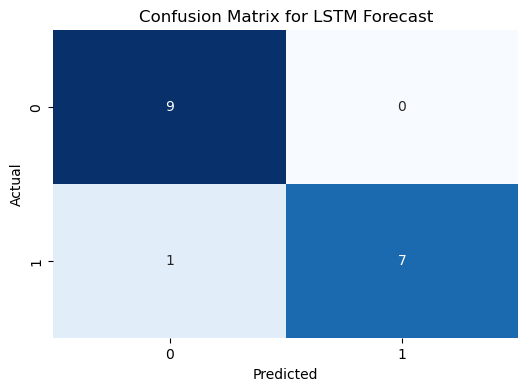

In [61]:
#graph confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for LSTM Forecast")
plt.show()

In [62]:
# Classification Report (Precision, Recall, F1-score)
report = classification_report(actual_labels, high_risk)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.88      0.93         8

    accuracy                           0.94        17
   macro avg       0.95      0.94      0.94        17
weighted avg       0.95      0.94      0.94        17

